# Rede Neural para Classificação de Mensagens de Texto Opinativo

<h3>Problema: </h3>

Classificar textos opinativos e identificar ideias inovadoras

Adaptado de: <br>
<ul>
    <li><a href="https://www.youtube.com/watch?v=hOCDJyZ6quA">https://www.youtube.com/watch?v=hOCDJyZ6quA</a></li>
    <li><a href="https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb">https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb</a></li>

</ul>

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

<h4>Importa os dados</h4>

In [2]:
df = pd.read_csv("dataset.csv", sep='@')
df.head(10)
# usar apenas coluna inovação

categoria                                           mensagem
0      spam  We got this GPS for my husband who is an (OTR)...
1      spam  I'm a professional OTR truck driver, and I bou...
2      inov  Well, what can I say.  I've had this unit in m...
3      inov  Not going to write a long review, even thought...
4      spam  I've had mine for a year and here's what we go...
5      spam  I am using this with a Nook HD+. It works as d...
6      spam  The cable is very wobbly and sometimes disconn...
7      spam  This adaptor is real easy to setup and use rig...
8      spam  This adapter easily connects my Nook HD 7" to ...
9      spam  This product really works great but I found th...

In [3]:
df.groupby('categoria').describe()

mensagem                                                            \
             count unique                                                top   
categoria                                                                      
inov           120    120  Very strong for any tv, but I wish that it was...   
spam          1380   1380  Once upon a time I travelled with a heavy curr...   

                
          freq  
categoria       
inov         1  
spam         1

In [4]:
df['spam']=df['categoria'].apply(lambda x: 0 if x=='spam' else 1)
df.head()

categoria                                           mensagem  spam
0      spam  We got this GPS for my husband who is an (OTR)...     0
1      spam  I'm a professional OTR truck driver, and I bou...     0
2      inov  Well, what can I say.  I've had this unit in m...     1
3      inov  Not going to write a long review, even thought...     1
4      spam  I've had mine for a year and here's what we go...     0

<h4>Divide os dados para treinamento e teste</h4>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['mensagem'],df['spam'], stratify=df['spam'])
X_train.head(4)

307     Excellent display quality. It runs fast, and d...
1410    Had a small setup problem (I needed to do the ...
2       Well, what can I say.  I've had this unit in m...
586     If i had known that the 3g is not good for any...
Name: mensagem, dtype: object

<h4>Importa o Bert (versão pré-treinada) e obtem vetores de embedding para algumas instruções de amostra </h4>

In [6]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [7]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "Very strong for any tv, but I wish that it was little longer I am very happy with it and very strongly recommended.", 
    "It is better than spending twice the money on this going into a brick and mortar store. Was very pleased."]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.86900216, -0.5040593 , -0.93927485, ..., -0.762481  ,
        -0.7207669 ,  0.9129089 ],
       [-0.8574518 , -0.4301609 , -0.97674876, ..., -0.927912  ,
        -0.6142683 ,  0.88937145]], dtype=float32)>

<h4>Obtem vetores de incorporação para algumas palavras simples. </h4>

In [8]:
e = get_sentence_embeding([
    "problem", 
    "maintenance",
    "manufacturer",
    "revision",
    "update",
    "upgrade",
    "water"
])

<h4>Realiza comparação usando similaridade de cosseno </h4>

Similaridade do cosseno: <br/>
0 significa que eles são muito diferentes.<br/>
1 significam que são semelhantes.  <br/>

<h4>Comparação entre "update" e "upgrade"</h4>

In [9]:
cosine_similarity([e[4]],[e[5]])

array([[0.9714235]], dtype=float32)

<h4>Comparação entre "problem" e "maintenance"</h4>

In [10]:
cosine_similarity([e[0]],[e[1]])

array([[0.94608295]], dtype=float32)

<h4>Comparação entre "upgrade" e "water"</h4>

In [11]:
cosine_similarity([e[2]],[e[6]])

array([[0.633726]], dtype=float32)

<h4>Construção do modelo BERT</h4>

In [12]:
# Camadas BERT
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Camadas da rede Neural
l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(50, activation='relu')(l)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Usa inputs and outputs para construir um modelo final
model = tf.keras.Model(inputs=[text_input], outputs = [l])

<h4>Estrutura e Configuração da Rede Neural</h4>

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

<h4>Compilação da Rede Neural</h4>

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<h4>Treinamento Histórico da Rede Neural</h4>

In [15]:
historico = model.fit(X_train, y_train, epochs=70, validation_data=(X_train, y_train))

Epoch 1/70
36/36 [==============================] - 327s 9s/step - loss: 0.3416 - accuracy: 0.8960 - val_loss: 0.3032 - val_accuracy: 0.9191
Epoch 2/70
36/36 [==============================] - 327s 9s/step - loss: 0.2885 - accuracy: 0.9200 - val_loss: 0.2795 - val_accuracy: 0.9200
Epoch 3/70
36/36 [==============================] - 334s 9s/step - loss: 0.2734 - accuracy: 0.9200 - val_loss: 0.2687 - val_accuracy: 0.9200
Epoch 4/70
36/36 [==============================] - 345s 10s/step - loss: 0.2736 - accuracy: 0.9200 - val_loss: 0.2751 - val_accuracy: 0.9200
Epoch 5/70
36/36 [==============================] - 332s 9s/step - loss: 0.2725 - accuracy: 0.9200 - val_loss: 0.2696 - val_accuracy: 0.9200
Epoch 6/70
36/36 [==============================] - 330s 9s/step - loss: 0.2685 - accuracy: 0.9200 - val_loss: 0.2622 - val_accuracy: 0.9200
Epoch 7/70
36/36 [==============================] - 331s 9s/step - loss: 0.2668 - accuracy: 0.9200 - val_loss: 0.2846 - val_accuracy: 0.9200
Epoch 8/70
3

<h2> Avaliação do modelo</h2>

In [16]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 55s 5s/step - loss: 0.3042 - accuracy: 0.9200


[0.3042498230934143, 0.9200000166893005]

<h4>Taxa de Perda da Rede Neural</h4>

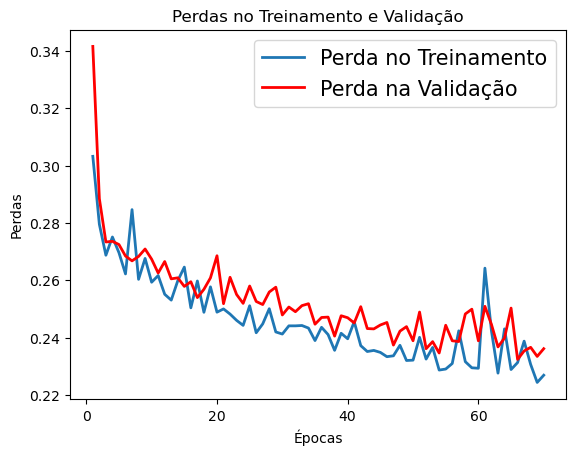

In [17]:
perda = historico.history['loss']
valor_perda = historico.history['val_loss']
epoca = range(1 , len(perda) + 1)

plt.style.use('default')
plt.title('Perdas no Treinamento e Validação')
plt.xlabel('Épocas') 
plt.ylabel('Perdas')

valor_perda = plt.plot(epoca, valor_perda, label='Perda no Treinamento')
perda_treino = plt.plot(epoca, perda, label='Perda na Validação', color="r")

plt.setp(valor_perda, linewidth=2.0)
plt.setp(perda_treino, linewidth=2.0)

plt.rc('font', size = 15)
plt.rc('figure', figsize=[10,10])
plt.legend()
plt.show()

<h4>Taxa de Acurácia da Rede Neural</h4>

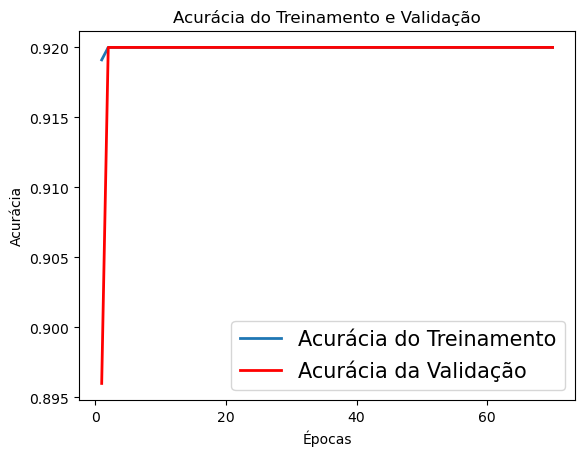

In [18]:
acuracia = historico.history['accuracy']
val_acuracia = historico.history['val_accuracy']
epoca = range(1, len(acuracia) + 1)

plt.style.use('default')
plt.title('Acurácia do Treinamento e Validação')
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')

valor_acuracia = plt.plot(epoca, val_acuracia, label='Acurácia do Treinamento')
acuracia_treino = plt.plot(epoca, acuracia, label='Acurácia da Validação', color="r")

plt.setp(valor_acuracia, linewidth=2.0)
plt.setp(acuracia_treino, linewidth=2.0)

plt.rc('font', size = 15)
plt.rc('figure', figsize=[10,10])
plt.legend()
plt.show()

<h4>Predição</h4>

In [19]:
# https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<h4>Matriz de Confusão</h4>

[[345   0]
 [ 30   0]]


<AxesSubplot:>

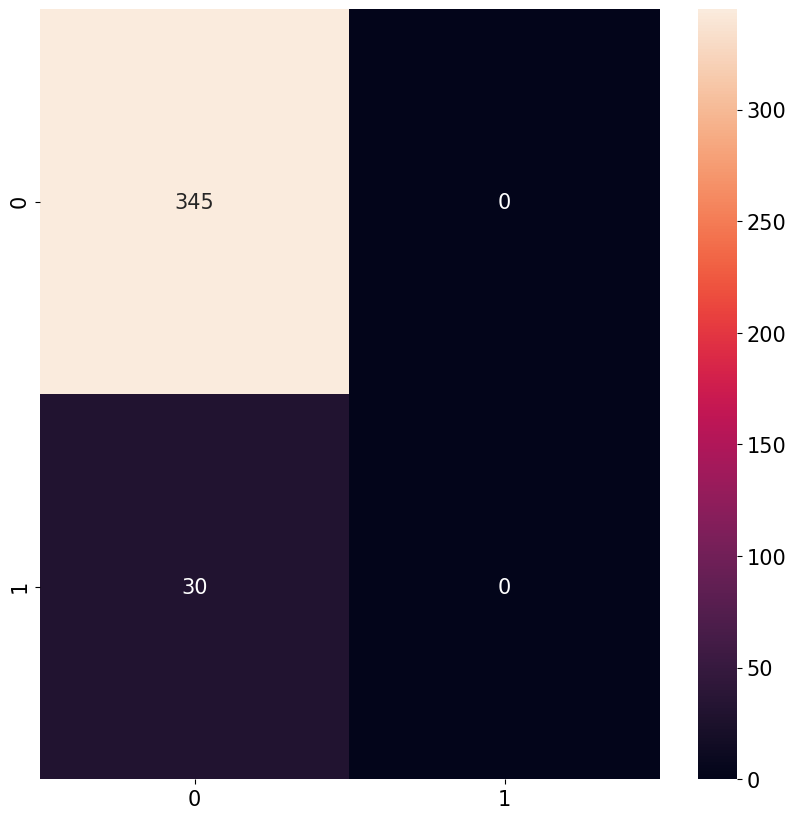

In [20]:
matriz = confusion_matrix(y_test, y_predicted)
print(matriz) 

sn.heatmap(matriz, annot=True, fmt='d')

<h4>Precisão x Recall x F1-Score</h4>

In [21]:
print(classification_report(y_test, y_predicted, target_names = ['spam','inov']))

              precision    recall  f1-score   support

        spam       0.92      1.00      0.96       345
        inov       0.00      0.00      0.00        30

    accuracy                           0.92       375
   macro avg       0.46      0.50      0.48       375
weighted avg       0.85      0.92      0.88       375



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
